# Detecting ice layers

In this notebook, we try to identify the formation of ice layers in the curve.
This is done by examining the global slope of inter-event portions of the lidar data in time, ad by assuming that the flat portions correspond to ice layers (otherwise we would observe some settling, thus non-flat).

In [1]:
import ddensity_ice

In [2]:
%run little_awk_functions.py

In [3]:
def simulate_snowpack_evolution_icy(ds, x_sel, y_sel, nb_iterations, end_accumulation_times, end_erosion_times,
                                start_accumulation_times, start_erosion_times,
                                start_accumulation, end_accumulation, start_erosion, end_erosion,
                                jj, dt, ro_layer, ro_water, ro_ice, t_old, tf, tsfc_default, dy_snow, gamma, cp_snow, melt_flag, a1, a1_value, a2,
                                slope_threshold, min_duration_in_s,
                                met_temp_data=[None], met_time_data=[0],
                                new_snow_ro=150, fit_top_of_snowfall_to_curve=False):
    '''
    TODO
    a1 is a VECTOR now
    '''
    
    # Initialize arrays to keep track of variables in time
    ro_layer_evolution = []
    depth_evolution = []
    temperature_evolution = []
    ice_layers_times = []

    # Initialize indices of next accumulation/erosion events coming up (updated when their time is past)
    accumulation_index = 0
    erosion_index = 0
    
    is_iced = False
    
    for i in range(nb_iterations):
    
    # TODO incorporate into simulation_of_snowpack_evolution: at each end of event: check what is the next event (accumulation or erosion) 
    # > check if there is ice detected (have an option for if want to detect ice)
    # > if not, keep as usual.
    # make a1 a vector
    # if ice is detected > stop compaction (set some params to values such that new_ro = ro ? > need to make a1 a vector, and set values to 0 if ice)
    # for all layers from top to last ice layer
    
    # TODO once tested (find a way to test it) on the simplified version of snowpack_evolution, incorporate into real deal function
    
    

        if accumulation_index<len(end_accumulation_times) and i*dt>=end_accumulation_times[accumulation_index]:
            
            if accumulation_index+1 >= len(start_accumulation_times) and erosion_index >= len(start_erosion_times):   # got to the end    # TODO Nope c'est pas la bonne condition, faut separer plus de cas
                if is_detected_ice(ds, x_sel, y_sel, end_accumulation, range(len(ds.time.values)), accumulation_index, -1, dt, slope_threshold, min_duration_in_s):
                    is_iced=True
            elif accumulation_index+1 < len(start_accumulation_times) and (erosion_index>=len(start_erosion_times) or start_accumulation_times[accumulation_index+1]<start_erosion_times[erosion_index]):  # next event will be an accumulation
                if is_detected_ice(ds, x_sel, y_sel, end_accumulation, start_accumulation, accumulation_index, accumulation_index+1, dt, slope_threshold, min_duration_in_s):
                    is_iced=True  
            elif erosion_index < len(start_erosion_times) and (accumulation_index+1>=len(start_accumulation_times) or start_accumulation_times[accumulation_index+1]>start_erosion_times[erosion_index]):  # next event will be an erosion
                if is_detected_ice(ds, x_sel, y_sel, end_accumulation, start_erosion, accumulation_index, erosion_index, dt, slope_threshold, min_duration_in_s):
                    is_iced=True
                    
            if is_iced:
                ice_layers_times.append(i)
                for i in range(jj+1):
                    a1[i] = 0
            else:
                a1[jj] = a1_value
            is_iced = False
            
            ddepth = get_change_in_snow_depth(ds, start_accumulation, end_accumulation, accumulation_index, x_sel, y_sel)
            ro_layer[jj] = new_snow_ro
            t_old[jj] = tsfc
            dy_snow[jj] = ddepth
            melt_flag[jj] = 0
            jj += 1
            accumulation_index += 1
    
        if erosion_index<len(end_erosion_times) and i*dt>=end_erosion_times[erosion_index]:
            
            if accumulation_index >= len(start_accumulation_times) and erosion_index+1 >= len(start_erosion_times):   # got to the end
                if is_detected_ice(ds, x_sel, y_sel, end_erosion, range(len(ds.time.values)), erosion_index, -1, dt, slope_threshold, min_duration_in_s):
                    is_iced=True
            elif accumulation_index < len(start_accumulation_times) and (erosion_index+1>=len(start_erosion_times) or start_accumulation_times[accumulation_index]<start_erosion_times[erosion_index+1]):   # next event will be an accumulation
                if is_detected_ice(ds, x_sel, y_sel, end_erosion, start_accumulation, erosion_index, accumulation_index, dt, slope_threshold, min_duration_in_s):
                    is_iced=True
            elif erosion_index+1 < len(start_erosion_times) and (accumulation_index>=len(start_accumulation_times) or start_accumulation_times[accumulation_index]>start_erosion_times[erosion_index+1]):   # next event will be an erosion
                if is_detected_ice(ds, x_sel, y_sel, end_erosion, start_erosion, erosion_index, erosion_index+1, dt, slope_threshold, min_duration_in_s):
                    is_iced=True
                    
            if is_iced:
                ice_layers_times.append(i)
                for i in range(jj+1):
                    a1[i] = 0
            else:
                a1[jj] = a1_value
            is_iced = False
            
            
            
            
            ddepth = get_change_in_snow_depth(ds, start_erosion, end_erosion, erosion_index, x_sel, y_sel)
            erosion_index += 1
            if jj>0:
                if dy_snow[jj-1] > ddepth:
                    dy_snow[jj-1] = dy_snow[jj-1] - ddepth
                else:
                    jj -= 1
                    dy_snow[jj] = 0
                    ro_layer[jj] = 0
                    t_old[jj] = 0
                    melt_flag[jj] = 0
    
        # Update layers' parameters
        ro_layer, dy_snow = ddensity_ice.ddensity_ml(ro_layer, tf, dt, ro_water, ro_ice, t_old, jj, dy_snow, a1, a2)
        t_old = snowtemp.snowtemp_ml(gamma, t_old, tsfc, jj, dt, ro_layer, cp_snow, tf, dy_snow, melt_flag)
        # print(t_old, jj)           # TODO take this out
    
        # Keep track of events
        ro_layer_evolution.append(ro_layer)
        depth_evolution.append(dy_snow)
        temperature_evolution.append(t_old)
        
    return(ro_layer_evolution, depth_evolution, temperature_evolution, ice_layers_times)

In [4]:
def simulate_snowpack_evolution_icy_from_met(ds, x_sel, y_sel, nb_iterations, end_accumulation_times, end_erosion_times,
                                start_accumulation_times, start_erosion_times,
                                start_accumulation, end_accumulation, start_erosion, end_erosion,
                                jj, dt, ro_layer, ro_water, ro_ice, t_old, tf, tsfc_default, dy_snow, gamma, cp_snow, melt_flag, a1, a1_value, a2,
                                min_duration_in_s,
                                met_temp_data, met_time_data,
                                new_snow_ro=150, fit_top_of_snowfall_to_curve=False):
    '''
    TODO
    a1 is a VECTOR now
    '''
    
    # Initialize arrays to keep track of variables in time
    ro_layer_evolution = []
    depth_evolution = []
    temperature_evolution = []
    ice_layers_times = []

    # Initialize indices of next accumulation/erosion events coming up (updated when their time is past)
    accumulation_index = 0
    erosion_index = 0
    high_temp_index = 0
    
    high_temps = ice_from_met_periods(0, met_temp_data, met_time_data, min_duration_in_s)
    start_high_temp_indices, end_high_temp_indices = high_temps[0], high_temps[1]
    
    for i in range(nb_iterations):
        
        if high_temp_index<len(start_high_temp_indices) and i*dt>=start_high_temp_indices[high_temp_index]:
            ice_layers_times.append(i)     # TODO problem here, all the i are added to ice_layer_times
            for i in range(jj+1):
                a1[i] = 0
            if i*dt>=end_high_temp_indices[high_temp_index]:
                high_temp_index += 1
        else:
            a1[jj] = a1_value
                
    # TODO once tested (find a way to test it) on the simplified version of snowpack_evolution, incorporate into real deal function

        if accumulation_index<len(end_accumulation_times) and i*dt>=end_accumulation_times[accumulation_index]:
            ddepth = get_change_in_snow_depth(ds, start_accumulation, end_accumulation, accumulation_index, x_sel, y_sel)
            ro_layer[jj] = new_snow_ro
            t_old[jj] = tsfc
            dy_snow[jj] = ddepth
            melt_flag[jj] = 0
            jj += 1
            accumulation_index += 1
    
        if erosion_index<len(end_erosion_times) and i*dt>=end_erosion_times[erosion_index]:
            ddepth = get_change_in_snow_depth(ds, start_erosion, end_erosion, erosion_index, x_sel, y_sel)
            erosion_index += 1
            if jj>0:
                if dy_snow[jj-1] > ddepth:
                    dy_snow[jj-1] = dy_snow[jj-1] - ddepth
                else:
                    jj -= 1
                    dy_snow[jj] = 0
                    ro_layer[jj] = 0
                    t_old[jj] = 0
                    melt_flag[jj] = 0
    
        # Update layers' parameters
        ro_layer, dy_snow = ddensity_ice.ddensity_ml(ro_layer, tf, dt, ro_water, ro_ice, t_old, jj, dy_snow, a1, a2)
        t_old = snowtemp.snowtemp_ml(gamma, t_old, tsfc, jj, dt, ro_layer, cp_snow, tf, dy_snow, melt_flag)
        # print(t_old, jj)           # TODO take this out
    
        # Keep track of events
        ro_layer_evolution.append(ro_layer)
        depth_evolution.append(dy_snow)
        temperature_evolution.append(t_old)
        
    return(ro_layer_evolution, depth_evolution, temperature_evolution, ice_layers_times)

In [5]:
def is_detected_ice(ds, x_sel, y_sel, end_events, start_events, index_of_end_event, index_of_start_event, dt, slope_threshold, min_duration_in_s):
    '''
    TODO
    Args:
        ds: clean dataset
        x_sel: index of the x-coordinate of the point of interest
        y_sel: index of the y-coordinate of the point of interest
        end_events: list of time indices at which the events of interest (accumulation or erosion, corresponding to event right before compaction time period) ended
        start_events: list of time indices at which the events of interest (accumulation or erosion, corresponding to event right before compaction time period) started
        index_of_end_event: index of the event right before the compaction time period
        index_of_start_event: index of the event right after the compaction time period
        dt: timestep between two iterations of the simulation, in s
        slope_threshold: value below which the avrage slope is considered negligeable
        min_duration_in_s: minimum duration of an ice event, under which we consider there is no ice formation
    Returns:
    TODO
    '''
    
    start_date_of_ice = end_events[index_of_end_event]     # time index in ds
    end_date_of_ice = start_events[index_of_start_event]
    
    start_snow_height = float(ds.snow_surface.isel(x=x_sel, y=y_sel, time=start_date_of_ice))
    end_snow_height = float(ds.snow_surface.isel(x=x_sel, y=y_sel, time=end_date_of_ice))
    snow_level_change = abs(end_snow_height - start_snow_height)
    
    duration_of_ice = (float(ds.time.values[end_date_of_ice]) - float(ds.time.values[start_date_of_ice])) / 1000000000  # in s
    
    if duration_of_ice < min_duration_in_s:
        return(False)
    
    else:
        slope_of_curve_during_ice = snow_level_change / duration_of_ice    # absolute value

        if slope_of_curve_during_ice < slope_threshold:   # in this case, consider there has been no compaction => ice
            return(True)
        else:
            return(False)


In [6]:
def ice_from_met_periods(timestamp, met_temp_data, met_time_data, min_duration_of_high_temp_in_s):
    '''
    TODO
    '''
    met_temp_no_nan = []
    met_time_no_nan = []
    
    for temp_index in range(len(met_temp_data)):
        if met_temp_data[temp_index] != None:
            met_temp_no_nan.append(met_temp_data[temp_index])
            met_time_no_nan.append(met_time_data[temp_index])
            
    high_temp_periods = np.array(met_temp_no_nan) > 0.0   # booleans
    
    high_temp_periods = np.diff(high_temp_periods.astype(int))   # 1 or 0
    
    start_time_indices = list(np.where(high_temp_periods==1)[0])
    end_time_indices = list(np.where(high_temp_periods==-1)[0])
    
    # If two high temperature events are close enough, consider them as a single event:
    time_index = 0
    while time_index < len(start_time_indices)-1:
        if start_time_indices[time_index] > start_time_indices[time_index+1]-15:      # TODO modularity
            start_time_indices.pop(time_index+1)
            end_time_indices.pop(time_index)
        time_index += 1
        
    time_index = 0
    while time_index < len(end_time_indices)-1:
        if end_time_indices[time_index] > end_time_indices[time_index+1]-15:      # TODO modularity
            start_time_indices.pop(time_index+1)
            end_time_indices.pop(time_index)
        time_index += 1
    
    # If a high temperature event lasts less than the minimum duration defined, consider it s negligeable:
    time_index = 0
    while time_index < len(end_time_indices)-1:
        if met_time_no_nan[end_time_indices[time_index]] - met_time_no_nan[start_time_indices[time_index]] < min_duration_of_high_temp_in_s:       
            # TODO there seems to be a serious problem here, figure out why (see graphs below)
            start_time_indices.pop(time_index)
            end_time_indices.pop(time_index)
        time_index += 1
        
    #print(start_time_indices, end_time_indices)
    
    #plt.figure(figsize=(38,8))
    #for i in start_time_indices:
     #   plt.plot(met_time_no_nan[i], 1, c='r', marker='v')
    #for i in end_time_indices:
     #   plt.plot(met_time_no_nan[i], 1, c='y', marker='v')
        
    return(start_time_indices, end_time_indices)
        
    '''
    for time_index in range(len(start_time_indices)):
        if met_time_no_nan[start_time_indices[time_index]] <= timestamp and met_time_no_nan[end_time_indices[time_index]] >= timestamp:
            return(True)
        
    return(False)
    '''

In [7]:
print(met_time_no_nan[1094])
print(met_time_no_nan[1095])

NameError: name 'met_time_no_nan' is not defined

[1100, 1133, 1661, 5475, 5559, 5647, 6121, 9109, 9358, 12248, 12321, 13423] [1119, 1165, 1680, 5484, 5560, 5656, 6155, 9314, 9364, 12276, 12333, 13438]


False

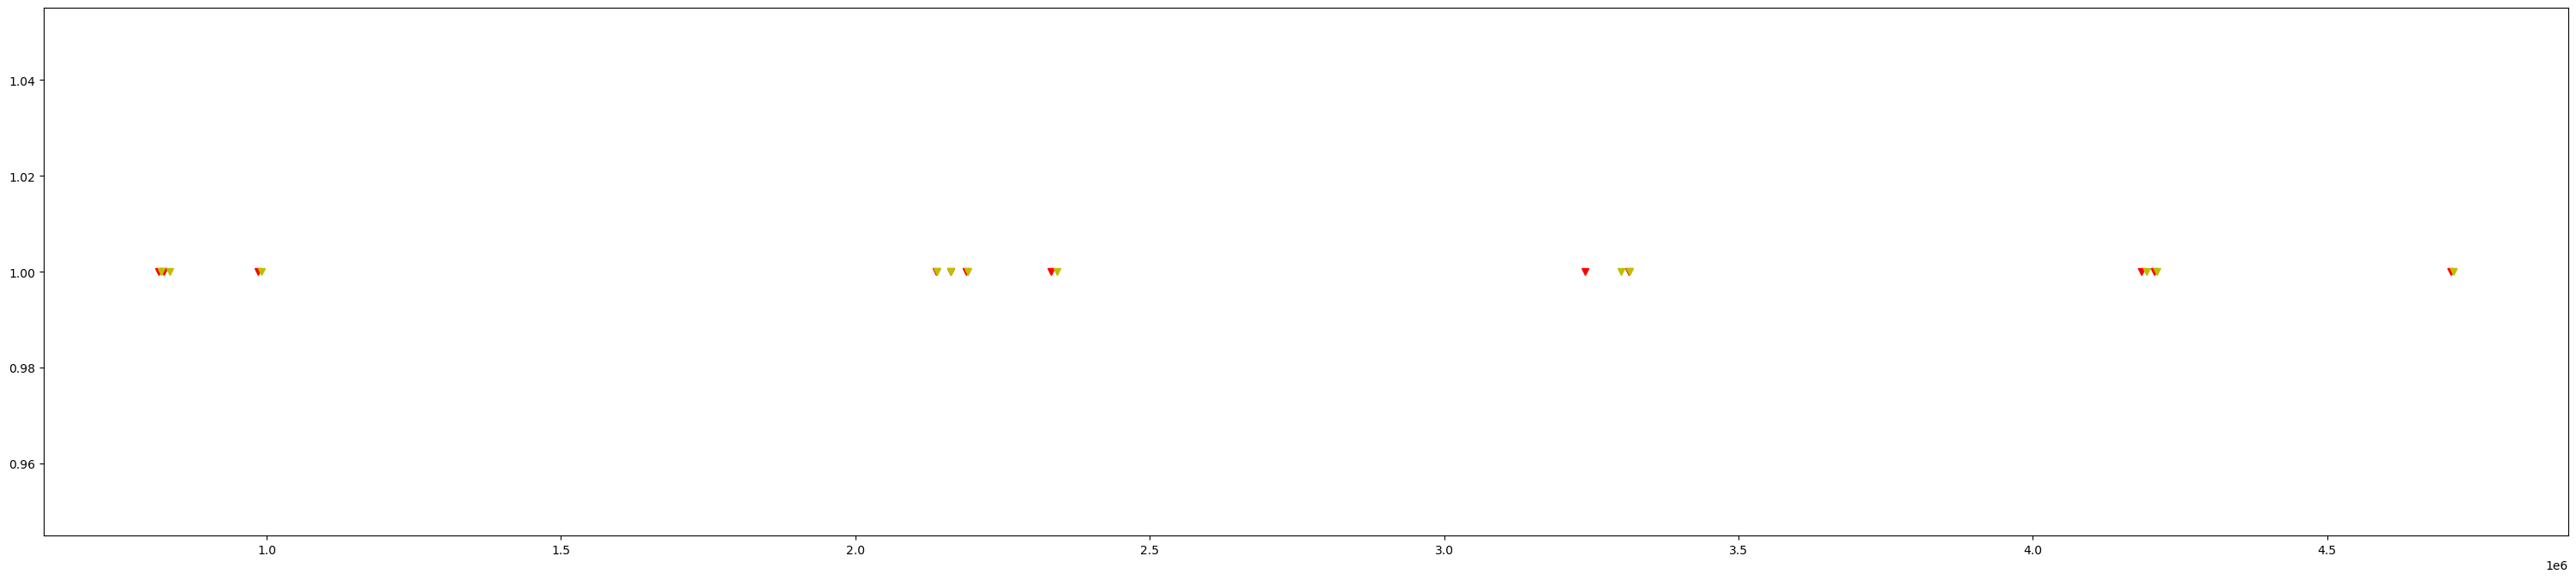

In [119]:
is_detected_ice_from_met(813900.5, met_temp, met_time, 10000000000)
# Problem: there should be a lot less intervals here

[1100, 1133, 1661, 5475, 5559, 5647, 6121, 9109, 9358, 12248, 12321, 13423] [1119, 1165, 1680, 5484, 5560, 5656, 6155, 9314, 9364, 12276, 12333, 13438]


False

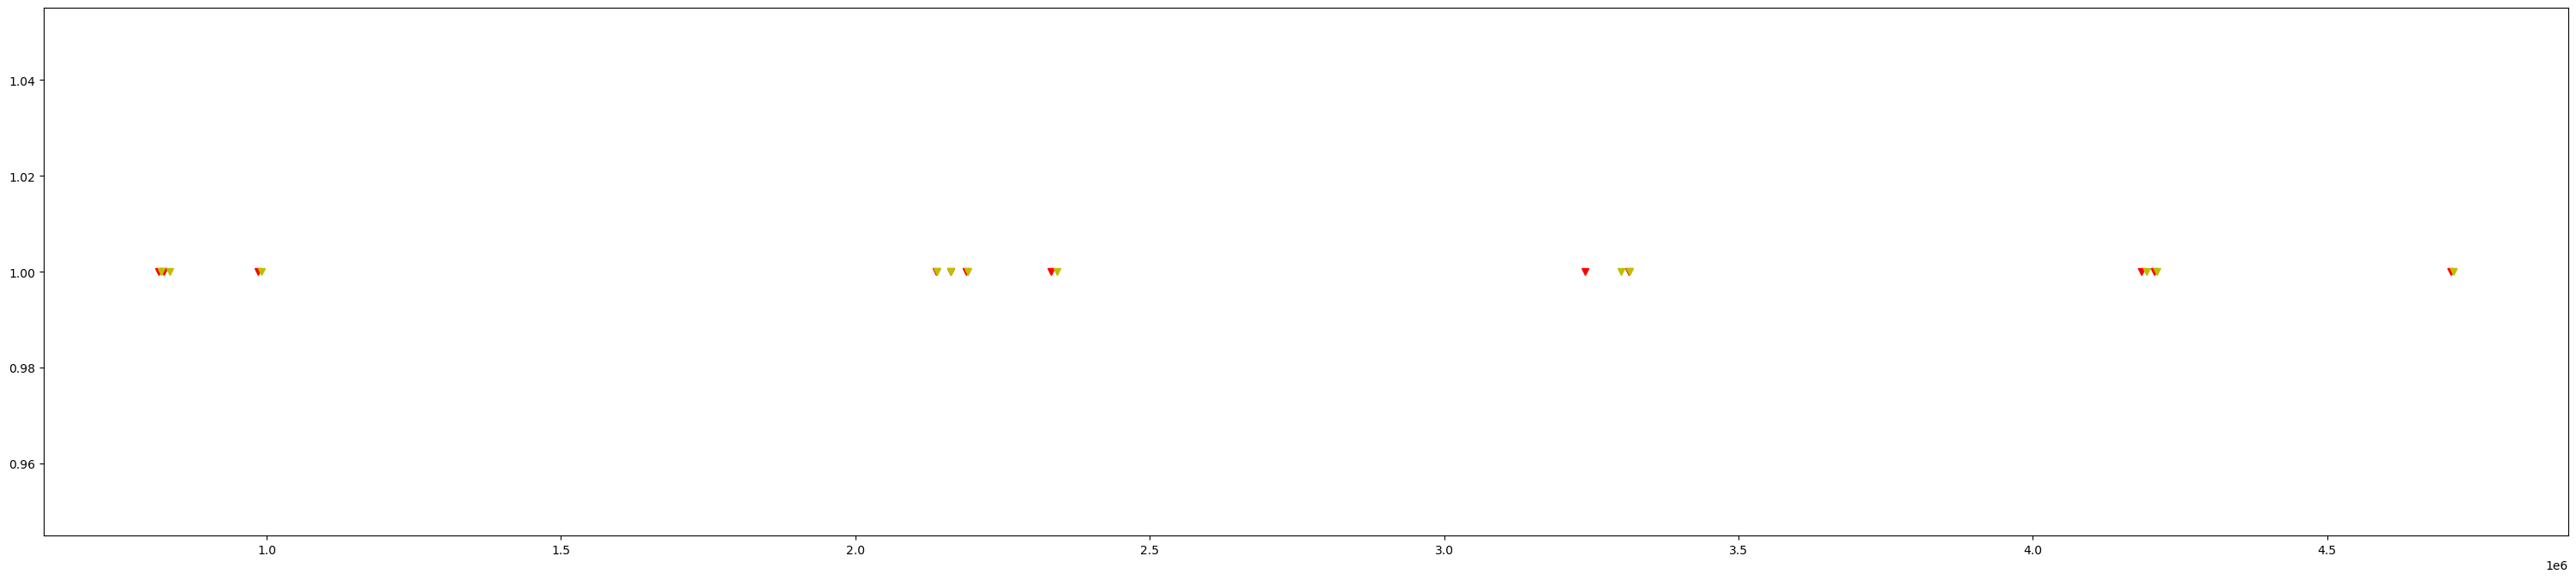

In [113]:
is_detected_ice_from_met(813900.5, met_temp, met_time, 100000)

[939, 1120, 1616, 1732, 5488, 5624, 5664, 6121, 9109, 9320, 9370, 12278, 13366, 13423] [1095, 1131, 1648, 1951, 5540, 5642, 5678, 6155, 9314, 9357, 9517, 12319, 13420, 13438]


True

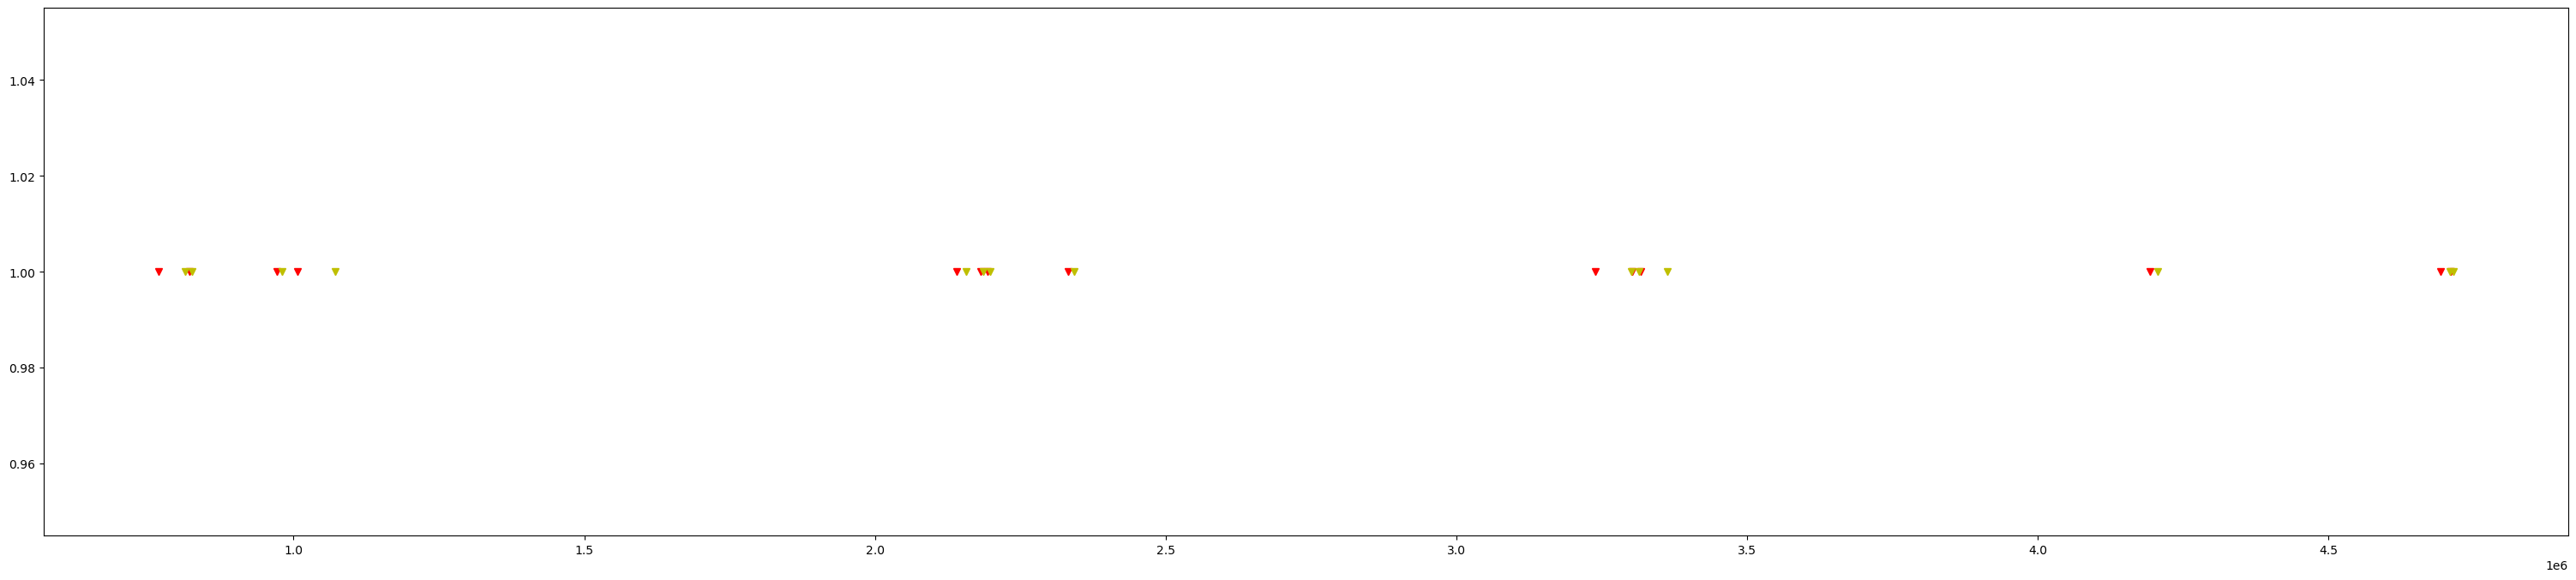

In [114]:
is_detected_ice_from_met(813900.5, met_temp, met_time, 10000)
# Problem: the intervals here should be a "over-set" of the events defined right above

## Define data

In [8]:
# Get data from files

# data_dec_jan_fev = xr.open_mfdataset('/home/mabonnet/Desktop/data/Data_netcdf/20*/202*.nc', chunks={'x': 20,'y': 20, 'time': 10})
# data_dec_jan_fev.isel(x=slice(100,122), y=slice(45,67)).to_netcdf('data_dec_jan_feb_pit.nc')
# data_dec_jan_feb = xr.open_dataset('data_dec_jan_feb_pit.nc')

# all_data = xr.open_mfdataset('/home/mabonnet/Desktop/data/2021_2022_livox_surfaces/*.nc', chunks={'x': 20,'y': 20, 'time': 10})
# all_data.isel(x=slice(100,122), y=slice(45,67)).to_netcdf('data_2021-2022.nc')
# all_data_set = xr.open_dataset('data_2021-2022.nc')

# data_dec_jan_fev = xr.open_mfdataset('/home/mabonnet/Desktop/data/Data_netcdf/data-filled/*.nc', chunks={'x': 20,'y': 20, 'time': 10})
# data_dec_jan_fev.isel(x=slice(84,106), y=slice(28,50)).to_netcdf('snow_pit_1_filled.nc')
data_pit_1 = xr.open_dataset('snow_pit_1_filled.nc')

# data_dec_jan_fev = xr.open_mfdataset('/home/mabonnet/Desktop/data/Data_netcdf/data-filled/*.nc', chunks={'x': 20,'y': 20, 'time': 10})
# data_dec_jan_fev.isel(x=slice(105,127), y=slice(39,61)).to_netcdf('snow_pit_2_filled.nc')
data_pit_2 = xr.open_dataset('snow_pit_2_filled.nc')

# data_dec_jan_fev_filled = xr.open_mfdataset('/home/mabonnet/Desktop/data/Data_netcdf/data-filled/*.nc', chunks={'x': 20,'y': 20, 'time': 10})
# data_dec_jan_fev_filled.isel(x=slice(100,122), y=slice(45,67)).to_netcdf('data_dec_jan_feb_filled_pit.nc')
# data_dec_jan_feb_filled = xr.open_dataset('data_dec_jan_feb_filled_pit.nc')

## Define parameters

In [9]:
# Define which dataset to use in what follows (see options above)

data_set_used = data_pit_1


In [10]:
# Defining parameters for snow events detection

x_sel = 10
y_sel = 10
time_window_std = 25
std_threshold = 0.01      # TODO real value

# Initial state for compaction/temperature model, with 0 layers

# Adaptable parameters
tsfc = -25             # TODO real value
cp_snow = 2106
dt = 100
a1_value = 0.0013
a2 = 0.021

max_nb_of_layers = 25

use_true_temp = True   # set to True if want to use the correct temperature forcing
use_ice_model = True    # set to True if want to use the model that detects ice layers
slope_threshold = 0.25
min_duration_in_s = 10800        # TODO real value

simul_new_snow_ro = 150    # TODO real value
simul_fit_top_of_snowfall_to_curve = False

# 'Fixed' parameters
tf = 0
ro_water = 1000
ro_ice = 910
jj = 0

# Defining parameters for snowdepth figure

data_start_date = pd.to_datetime('2021-12-06T00:00')       # TODO real value
nb_layers_to_plot = 17
figure_size = (18, 9)
save_file_to_png = False
file_name = 'ice_detection.png'
title = 'Comparison between lidar-measured and simulated snow depth'

In [11]:
# Pre-processing to get clean data

data_set_used = data_set_used.ffill(dim='time')

median_space_filtering(data_set_used, 5, x_span=7)

data_set_used['snow_surface'] = data_set_used['snow_surface'] - data_set_used['snow_surface'].min() - 0.45414986 #- data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time= start_accumulation[0])
# TODO modular above


---> Median filtering in space with a window [7, 11]


In [12]:
# Define dates

data_starting_date_in_ns = float(data_set_used.time.values[0])

data_starting_date_in_s = pd.to_datetime(data_set_used.time.values[0]).timestamp()
data_ending_date_in_s = pd.to_datetime(data_set_used.time.values[-1]).timestamp()
data_duration_in_s = data_ending_date_in_s - data_starting_date_in_s
nb_iterations = int(data_duration_in_s/dt + 1)

# Define structures to store snow parameters

ro_layer = np.zeros((max_nb_of_layers, 1))
t_old = np.zeros((max_nb_of_layers, 1))
dy_snow = np.zeros((max_nb_of_layers, 1))
gamma = np.zeros((max_nb_of_layers, 1))
melt_flag = np.zeros((max_nb_of_layers, 1))
a1 = np.zeros((max_nb_of_layers, 1))


In [13]:
# Meteorological forcing

if use_true_temp:
    met_time, met_temp = get_met_forcing()
else:
    met_time, met_temp = [0], [tsfc]


## Get snow events timing

In [14]:

results = get_snow_events(data_set_used, x_sel, y_sel, time_window_std, std_threshold)
start_accumulation = results[0]
start_erosion = results[1]
end_accumulation = results[2]
end_erosion = results[3]

# Convert end times into more manageable orders of magnitude

end_accumulation_times = data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=end_accumulation)
end_accumulation_times = (pd.to_datetime(end_accumulation_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s

start_accumulation_times = data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=start_accumulation)
start_accumulation_times = (pd.to_datetime(start_accumulation_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s

end_erosion_times = data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=end_erosion)
end_erosion_times = (pd.to_datetime(end_erosion_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s

start_erosion_times = data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=start_erosion)
start_erosion_times = (pd.to_datetime(start_erosion_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s


## Simulate evolution of snowpack

In [17]:
# Update variables at each timepoint

if use_ice_model:
    snowpack = simulate_snowpack_evolution_icy(data_set_used, x_sel, y_sel, nb_iterations, end_accumulation_times, end_erosion_times,
                                       start_accumulation_times, start_erosion_times,
                                       start_accumulation, end_accumulation, start_erosion, end_erosion, jj, dt, ro_layer, ro_water, ro_ice,
                                       t_old, tf, tsfc, dy_snow, gamma, cp_snow, melt_flag, a1, a1_value, a2, 0.00000005, min_duration_in_s,    # TODO real value
                                       met_temp_data=met_temp,
                                       met_time_data=met_time, new_snow_ro=simul_new_snow_ro, fit_top_of_snowfall_to_curve=simul_fit_top_of_snowfall_to_curve)
    
    # snowpack = simulate_snowpack_evolution_icy_from_met(data_set_used, x_sel, y_sel, nb_iterations, end_accumulation_times, end_erosion_times,
                                       #start_accumulation_times, start_erosion_times,
                                       #start_accumulation, end_accumulation, start_erosion, end_erosion, jj, dt, ro_layer, ro_water, ro_ice,
                                       #t_old, tf, tsfc, dy_snow, gamma, cp_snow, melt_flag, a1, a1_value, a2, 100000,
                                       #met_temp, met_time, new_snow_ro=simul_new_snow_ro, fit_top_of_snowfall_to_curve=simul_fit_top_of_snowfall_to_curve)

    ro_layer_evolution, depth_evolution, temperature_evolution, ice_layers_times = snowpack[0], snowpack[1], snowpack[2], snowpack[3]

In [18]:
# ice_layers_times

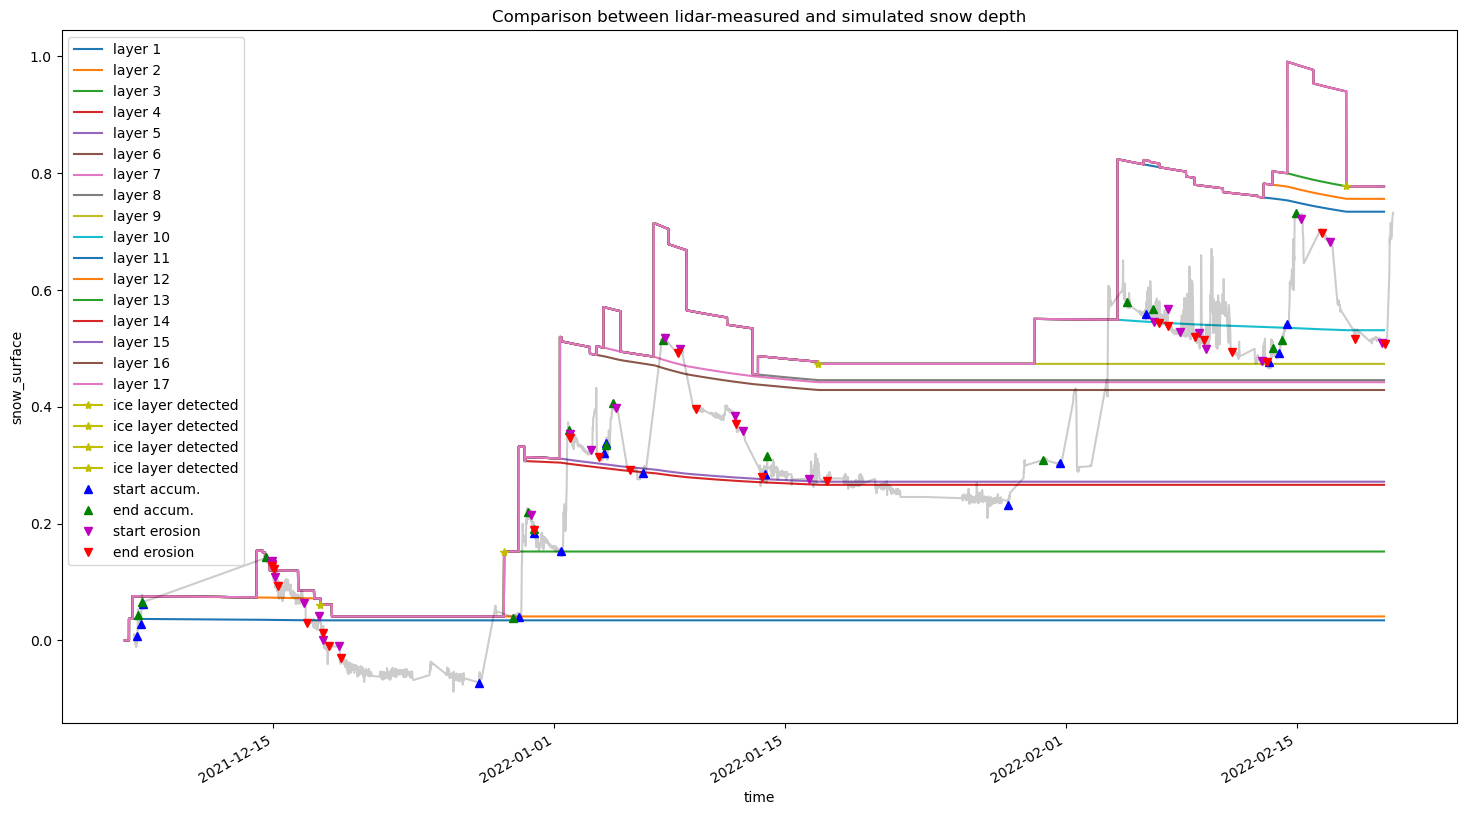

In [19]:
if use_ice_model:
    plot_simul_and_signal(data_set_used, x_sel, y_sel, depth_evolution, nb_layers_to_plot, data_start_date, dt, nb_iterations,
                      start_accumulation, end_accumulation, start_erosion, end_erosion, ice_layers_times_indices=ice_layers_times, my_figsize=figure_size,
                      save_file=save_file_to_png, my_file_name=file_name, my_title=title)

# TODO add parameters as subtitle automatically
# TODO find a way to only print the label 'ice layer detected' once, and make marker bigger/above curve

# TODO the execution is WAAAY much longer if use the model from the met data... > WHY??